In [1]:
import sys

sys.path.insert(0, '../')

import specutils
specutils

<module 'specutils' from '../specutils/__init__.py'>

In [110]:
from astropy.table import Table
from astropy.utils import data
from astropy.io import fits
from astropy import units as u
from astropy import constants as cnst
import numpy as np

In [66]:
%matplotlib inline
from matplotlib import pyplot as plt

# Downloads/prep

## SDSS Spectra

First lets grab a few example spectra from the SDSS.  These are fairly typical lowish resolution stellar spectra. We start by getting a convenient list of known nearish K/M-type stars.

In [76]:
sdss_qry = """
SELECT z, ra, dec, sourceType, targetType, secTarget, fiberID, plate, mjd, specObjID, bestObjID, fluxObjID, targetObjID, plateID, sn1_r, sn2_r, spectroFlux_r, subClass 
FROM specObj 
WHERE ancillary_target1 & dbo.fAncillaryTarget1('RED_KG') > 0 
"""

t = Table.read('red_kgs_eteq.csv')
t['avg_sn'] = (t['sn1_r'] + t['sn2_r'])/2
t.sort('avg_sn')
t.reverse()
t['spectype'] = [sc.split('(')[0].strip() for sc in t['subClass']]
t['lumclass'] = [''.join([char for char in st[2:] if char.isupper()]) for st in t['spectype']]
giants = t['lumclass'] == 'III'
np.sum(giants)

334

Now download a couple of giants chosen to span the S/N range of this sample.

In [ ]:
templ_spec_path = 'https://dr16.sdss.org/optical/spectrum/view/data/format=fits/spec=lite?plateid={plate}&mjd={mjd}&fiberid={fiberID}'

('K4III', <Quantity 87.08272388 km / s>)

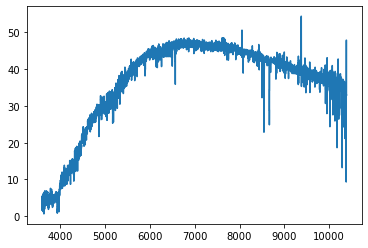

In [111]:
row = t[giants][0]
url = templ_spec_path.format(**{nm: row[nm] for nm in 'plate,mjd,fiberID'.split(',')})
fn = data.download_file(url, timeout=30)
brightspec = specutils.Spectrum1D.read(fn, format='SDSS-III/IV spec')

plt.step(brightspec.wavelength, brightspec.flux)
row['spectype'], row['z']*cnst.c.to(u.km/u.s)

('K2III', <Quantity -52.92302215 km / s>)

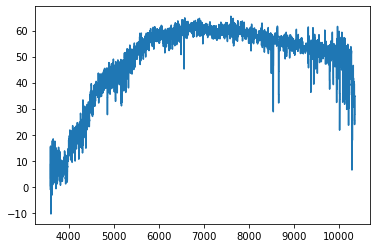

In [112]:
row = t[giants][-2]
url = templ_spec_path.format(**{nm: row[nm] for nm in 'plate,mjd,fiberID'.split(',')})
fn = data.download_file(url, timeout=30)
faintspec = specutils.Spectrum1D.read(fn, format='SDSS-III/IV spec')

plt.step(faintspec.wavelength, faintspec.flux)
row['spectype'], row['z']*cnst.c.to(u.km/u.s)

##  Template spectra

Use the Phoenix grids as the templates.  For example purposes we will just grab two, one that's about the right teff/logg for a K2III, and another more like a K4III:

In [ ]:
# note these are very slow downloads, so just recording urls here and downloaded separately
templ_logg2p5_teff5200_url = 'http://osubdd.ens-lyon.fr/phoenix/phoenix.cgi?c=i&a=mime:application/fits&o=phoenix:Grids/BT-Settl/CIFIST2011_2015/SPECTRA/lte052.0-2.5-0.0a+0.0.BT-Settl.spec.7.xz'
templ_logg2p5_teff4600_url = 'http://osubdd.ens-lyon.fr/phoenix/phoenix.cgi?c=i&a=mime:application/fits&o=phoenix:Grids/BT-Settl/CIFIST2011_2015/SPECTRA/lte046.0-2.5-0.0a+0.0.BT-Settl.spec.7.xz'

In [134]:
f46 = fits.open('phoenix_Grids_BT-Settl_CIFIST2011_2015_SPECTRA_lte046.0-2.5-0.0a 0.0.BT-Settl.spec.7.xz.fits')
templ_spec4600 = specutils.Spectrum1D(spectral_axis=f46[1].data['WAVELENGTH']*u.angstrom, 
                                      flux=f46[1].data['FLUX']*u.angstrom)

In [135]:
f52 = fits.open('phoenix_Grids_BT-Settl_CIFIST2011_2015_SPECTRA_lte052.0-2.5-0.0a 0.0.BT-Settl.spec.7.xz.fits')
templ_spec5200 = specutils.Spectrum1D(spectral_axis=f52[1].data['WAVELENGTH']*u.angstrom, 
                                      flux=f52[1].data['FLUX']*u.angstrom)

(8000, 9000)

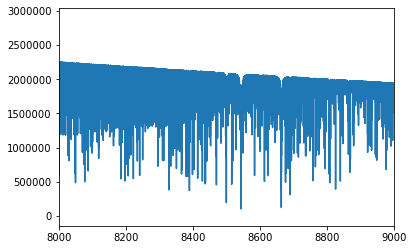

In [138]:
plt.step(templ_spec4600.wavelength, templ_spec4600.flux)
plt.xlim(8000, 9000)

Very different resolution... but lets see what happens:

In [143]:
from specutils.analysis.correlation import template_correlate # this should be from analysis not correlation

In [146]:
template_correlate(brightspec, templ_spec5200)

ValueError: operands could not be broadcast together with shapes (4608,) (1336340,) 

Hmmm.  Does not auto re-sample just as the docs say. Need to resample, but should smooth the template *first* to something slightly higher-res than the observed spectra.

* the docs do not mention the auto-log-resampler.  That's *critical* for acheiving best cross-correlation results.